# Copyright Netherlands eScience Center <br>
** Function     : Predict the extent of Sea Ice Concentration with LSTM ** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.04.17 ** <br>
** Last Update  : 2019.04.17 ** <br>
** Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, deepclim, matplotlib
Description     : This notebook serves to predict the Arctic sea ice using deep learning. As a pre-test, we start with time series of SIC extent anomalies. To make it easier, we use many climate index (to represent the forcing from atmosphere). In addtion,  <br>

The Long Short Time Memory neural network is used here. We use Pytorch as the deep learning framework. <br>

Return Values   : Time series and figures <br>

Here is the information of climate index in details:<br>
**NAO** @ 1950 Jan - 2018 Feb (818 records) <br>
http://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/nao.shtml <br>
**ENSO - NINO 3.4 SST** @ 1950 Jan - 2018 Jan (817 records) <br>
https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Nino34/ <br>
**AO** @ 1950 Jan - 2018 Feb (818 records) <br>
http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/ao.shtml <br>
**AMO** @ 1950 Jan - 2018 Feb (818 records) <br>
AMO unsmoothed, detrended from the Kaplan SST V2. The result is standarised.<br>
https://www.esrl.noaa.gov/psd/data/timeseries/AMO/<br>

(All the NOAA index shown above are given by NCEP/NCAR Reanalysis (CDAS))<br>

**PDO** @ 1900 Jan - 2018 Feb (1418 records)<br>
This PDO index comes from University of Washington, it contains SST data from the following 3 datasets:<br>
- UKMO Historical SST data set for 1900-81;
- Reynold's Optimally Interpolated SST (V1) for January 1982-Dec 2001)
- OI SST Version 2 (V2) beginning January 2002 -<br>

http://research.jisao.washington.edu/pdo/PDO.latest<br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/ML4Climate/Scripts/DeepClim")
# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import sklearn
#import scipy
import torch
import deepclim.preprocess

# for visualization
import deepclim.visual
import matplotlib
import matplotlib.pyplot as plt
import iris # also helps with regriding
import cartopy
import cartopy.crs as ccrs

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

** Data ** <br>
Time span of each product included: <br>
** Reanalysis ** <br>
- **ERA-Interim** 1979 - 2016 (ECMWF)
- **ORAS4**       1958 - 2014 (ECMWF)

** Index ** <br>
- **NINO3.4**     1950 - 2017 (NOAA)
- **AO**          1950 - 2017 (NOAA)
- **NAO**         1950 - 2017 (NOAA)
- **AMO**         1950 - 2017 (NOAA)
- **PDO**         1950 - 2017 (University of Washington)

!! These index are given by NCEP/NCAR Reanalysis (CDAS) <br>


Alternative (not in use yet) <br>
** Reanalysis ** <br>
- **MERRA2**      1980 - 2016 (NASA)
- **JRA55**       1979 - 2015 (JMA)
- **GLORYS2V3**   1993 - 2014 (Mercartor Ocean)
- **SODA3**       1980 - 2015
- **PIOMASS**     1980 - 2015

** Observations ** <br>
- **NSIDC**       1958 - 2017 

In [3]:
################################   path  ######################################
# please specify data path
datapath_ERAI = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
datapath_ORAS4 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met'
datapath_ORAS4_mask = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4'
datapath_PIOMASS = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/PIOMASS'
datapath_clim_index = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/Climate_index'
output_path = '/home/ESLT0068/NLeSC/Computation_Modeling/ML4Climate/PredictArctic/Series'

In [4]:
if __name__=="__main__":
    print ('*********************** get the key to the datasets *************************')
    dataset_ERAI_fields_SIC_SST_SLP = Dataset(os.path.join(datapath_ERAI,
                                              'surface_ERAI_monthly_regress_1979_2016.nc'))

    dataset_PIOMASS_siv = Dataset(os.path.join(datapath_PIOMASS,
                                       'siv_monthly_PIOMASS_1979_2017.nc'))
    dataset_ORAS4_OHC = Dataset(os.path.join(datapath_ORAS4,
                                             'oras_model_monthly_1958_2017_ohc.nc'))
    dataset_index = Dataset(os.path.join(datapath_clim_index,
                                         'index_climate_monthly_regress_1950_2017.nc'))
    #dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
    #                                  'surface_erai_monthly_regress_1979_2017_radiation.nc'))
    # mask
    dataset_ORAS4_mask = Dataset(os.path.join(datapath_ORAS4_mask, 'mesh_mask.nc'))
    print ('*********************** extract variables *************************')
    # ********************************** data gallery *************************************** #
    # we use time series from 1979 to 2016 (468 months in total)
    # training data: 1979 - 2006
    # validation: 2007 - 2016
    # variables list:
    # SIC (ERA-Interim) / SIV (PIOMASS) / SST (ERA-Interim) / ST (ERA-Interim) / OHC (ORAS4) / AO-NAO-AMO-NINO3.4 (NOAA)
    # integrals from spatial fields cover the area from 20N - 90N (4D fields [year, month, lat, lon])
    # *************************************************************************************** #
    # SIC (ERA-Interim)
    SIC_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['ci'][:,:95,:] # 3D fields [time, lat, lon]
    #SIC_ERAI_mask = np.ma.getmaskarray(SIC_ERAI[0,:,:])
    time_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['time'][:]
    latitude_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['latitude'][:]
    longitude_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['longitude'][:]
    #SIV (PIOMASS)
    SIV_PIOMASS = dataset_PIOMASS_siv.variables['SIV'][:-12]
    year_SIV = dataset_PIOMASS_siv.variables['year'][:-1]
    # SST (ERA-Interim)
    SST_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['sst'][:,:95,:] # 3D fields [time, lat, lon]
    # dimensions the same as above
    # ST (ERA-Interim)
    # OHC (ORAS4)
    OHC_100_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_100_int'][21:-1,:,180:]/1000 # unit Peta Joule
    OHC_300_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_300_int'][21:-1,:,180:]/1000
    OHC_700_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_700_int'][21:-1,:,180:]/1000
    #OHC_2000_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_2000_int'][21:-1,:,180:]/1000
    
    latitude_OHC_ORAS4 = dataset_ORAS4_OHC.variables['latitude_aux'][180:]
    #gphiv_OHC_ORAS4 = dataset_ORAS4_OHC.variables['gphiv'][180:,:]
    #glamv_OHC_ORAS4 = dataset_ORAS4_OHC.variables['glamv'][180:,:]
    # AO-NAO-AMO-NINO3.4 (NOAA)
    AO = dataset_index.variables['AO'][348:-12] # from 1979 - 2016
    NAO = dataset_index.variables['NAO'][348:-12]
    NINO = dataset_index.variables['NINO'][348:-12]
    AMO = dataset_index.variables['AMO'][348:-12]
    PDO = dataset_index.variables['PDO'][348:-12]
    
    # radiation flux
    #rad_short_toa_ERAI = dataset_ERAI_fields_flux.variables['tsr'][:] # unit Watt/m2
    #rad_long_toa_ERAI = dataset_ERAI_fields_flux.variables['ttr'][:] # unit Watt/m2
    #rad_short_surf_ERAI = dataset_ERAI_fields_flux.variables['ssr'][:] # unit Watt/m2
    #rad_long_surf_ERAI = dataset_ERAI_fields_flux.variables['str'][:] # unit Watt/m2
    # turbulent flux
    #SFlux_sensible_ERAI = dataset_ERAI_fields_flux.variables['sshf'][:] # unit Watt/m2
    #SFlux_latent_ERAI = dataset_ERAI_fields_flux.variables['slhf'][:] # unit Watt/m2

*********************** get the key to the datasets *************************
*********************** extract variables *************************


In [ ]:
    print (latitude_ERAI[:41])
    print (latitude_OHC_ORAS4[53:])
    print (SIC)

In [5]:
    print ('******************  calculate extent from spatial fields  *******************')
    # size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_ERAI /
                                            360) / len(longitude_ERAI)
    dy = np.pi * constant['R'] / len(latitude_ERAI)
    # calculate the sea ice area
    SIC_ERAI_area = np.zeros(SIC_ERAI.shape, dtype=float)
    for i in np.arange(len(latitude_ERAI[:95])):
        # change the unit to terawatt
        SIC_ERAI_area[:,i,:] = SIC_ERAI[:,i,:]* dx[i] * dy # unit m2
    
    print ('******************  calculate mean/sum from spatial fields  *******************')
    # calculate the mean SST in the polar cap
    SST_ERAI_mean = np.mean(np.mean(SST_ERAI[:,:41,:],2),1)
    # calculate the total OHC in the polar cap
    OHC_100_ORAS4_sum = np.sum(OHC_100_int_ORAS4[:,:,53:],2)
    OHC_300_ORAS4_sum = np.sum(OHC_300_int_ORAS4[:,:,53:],2)
    OHC_700_ORAS4_sum = np.sum(OHC_700_int_ORAS4[:,:,53:],2)
    # calculate the total SIC in the polar cap
    SIC_ERAI_sum = np.sum(np.sum(SIC_ERAI_area[:,:41,:],2),1)

******************  calculate extent from spatial fields  *******************
******************  calculate mean/sum from spatial fields  *******************


In [6]:
    print ('*******************  pre-processing  *********************')
    print ('================  reshape input data into time series  =================')
    OHC_700_ORAS4_sum_series= deepclim.preprocess.operator.unfold(OHC_700_ORAS4_sum)
    print ('================  normalize data  =================')
    SIC_ERAI_sum_norm = deepclim.preprocess.operator.normalize(SIC_ERAI_sum)
    SIV_PIOMASS_norm = deepclim.preprocess.operator.normalize(SIV_PIOMASS)

*******************  pre-processing  *********************
================  reshape input data into time series  =================
================  normalize data  =================


*******************  preview of input time series  *********************
(456, 1, 1)


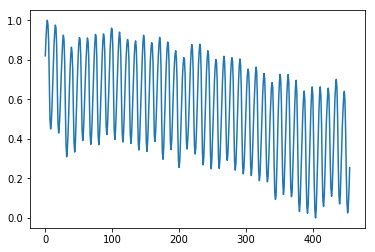

In [20]:
    print ('*******************  preview of input time series  *********************')
    #plt.plot(SIC_ERAI_sum)
    plt.plot(SIV_PIOMASS_norm)
    #a = np.expand_dims(SIC_ERAI_sum_norm,axis=1)

# Procedure for LSTM <br>
** We use Pytorth to implement LSTM neural network with time series of climate data. ** <br>

In [14]:
    print ('*******************  create basic dimensions for tensor and network  *********************')
    print (torch.__version__)
    # check if CUDA is available
    use_cuda = torch.cuda.is_available()
    print("Is CUDA available? {}".format(use_cuda))
    # standard LSTM input dimension
    # [sequence_length, batch_size, input_size]
    # example : x = torch.autograd.Variable(torch.randn(6, 3, 5))
    # prepare input array for LSTM input -> dimension
    # take 1 year as test data
    SIC = np.zeros((len(SIC_ERAI_sum_norm)-1*12,1,1),dtype=float)
    SIC[:,0,0] = SIC_ERAI_sum_norm[:-1*12]
    SIV = np.zeros((len(SIV_PIOMASS_norm)-1*12,1,1),dtype=float)
    SIV[:,0,0] = SIV_PIOMASS_norm[:-1*12]
    # create variables
    SIC_var = torch.autograd.Variable(torch.Tensor(SIC))
    SIV_var = torch.autograd.Variable(torch.Tensor(SIV))
    # specifications of neural network
    input_size = 1
    hidden_size = 1
    batch_size = 1
    output_size = 1
    num_layers = 1
    learning_rate = 0.01
    num_epochs = 200

*******************  create basic dimensions for tensor and network  *********************
1.0.1.post2
Is CUDA available? False


In [8]:
class LSTM(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                 num_layers=2):
        """
        Initialize the LSTM module in Pytorch and specify the basic model structure.
        """
        super(LSTM, self).__init__() #inheritance https://realpython.com/python-super/
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = torch.nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = torch.nn.Linear(self.hidden_dim, output_dim)
    
    def init_hidden(self):
        """
        Initialization of hidden state. We create two matrix: hidden and cell.
        The shape of the matrix should be: 
        torch.randn(self.num_layers, self.batch_size, self.hidden_dim)
        """
        
        return (torch.randn(self.num_layers, self.batch_size, self.hidden_dim),
                torch.randn(self.num_layers, self.batch_size, self.hidden_dim))
    
    def forward(self, input):
        """
        Forward pass through LSTM layer.
        The shape of lstm_out: [input_size, batch_size, hidden_dim]
        The shape of self.hidden: (hn, cn), where hn and cn both
        have shape (num_layers, batch_size, hidden_dim).
        More information is available:
        https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#sphx-glr-beginner-nlp-sequence-models-tutorial-py
        """
        # matrix dimension as feed for lstm is fixed
        # torch.tensor.view(-1) adpat the array to a new shape with extra dimension [..,-1,..]
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1) # tensor.view only rearrange the array, not transpose

In [15]:
    print ('*******************  run LSTM  *********************')
    # choose training data
    y_train = SIV_var
    # initialize our model
    model = LSTM(input_size, hidden_size, batch_size=batch_size,
                 output_dim=output_size, num_layers=num_layers)
    loss_fn = torch.nn.MSELoss(size_average=False)
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #####################
    # Train Loop
    #####################
    hist = np.zeros(num_epochs)

    for t in range(num_epochs):
        # Clear stored gradient
        model.zero_grad()

        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        model.hidden = model.init_hidden()
    
        # Forward pass
        y_pred = model(SIV_var)

        loss = loss_fn(y_pred, y_train)
        if t % 10 == 0:
            print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()
    
        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
    
    #torch.save(model, 'lstm.pkl') # save lstm model

*******************  run LSTM  *********************
Epoch  0 MSE:  66.23576354980469


/home/ESLT0068/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch  10 MSE:  37.96071243286133
Epoch  20 MSE:  27.17059898376465
Epoch  30 MSE:  24.66269874572754
Epoch  40 MSE:  24.784992218017578
Epoch  50 MSE:  24.800512313842773
Epoch  60 MSE:  24.650089263916016
Epoch  70 MSE:  24.615230560302734
Epoch  80 MSE:  24.62165641784668
Epoch  90 MSE:  24.617290496826172
Epoch  100 MSE:  24.614898681640625
Epoch  110 MSE:  24.615188598632812
Epoch  120 MSE:  24.61499786376953
Epoch  130 MSE:  24.614896774291992
Epoch  140 MSE:  24.614913940429688
Epoch  150 MSE:  24.614898681640625
Epoch  160 MSE:  24.614896774291992
Epoch  170 MSE:  24.614896774291992
Epoch  180 MSE:  24.614896774291992
Epoch  190 MSE:  24.614896774291992


In [12]:
    print (model)
    print (y_pred.shape)

LSTM(
  (lstm): LSTM(1, 1)
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
torch.Size([1])


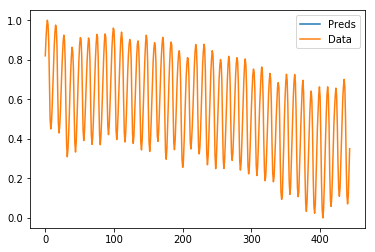

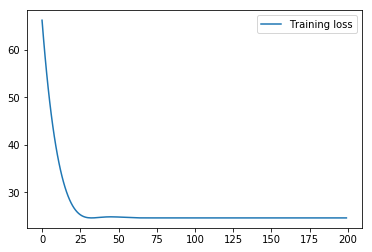

In [16]:
    # visualization
    plt.plot(y_pred.detach().numpy(), label="Preds")
    plt.plot(y_train[:,0,0].detach().numpy(), label="Data")
    plt.legend()
    plt.show()

    plt.plot(hist, label="Training loss")
    plt.legend()
    plt.show()

In [ ]:
    print ('*******************  run linear regression  *********************')
    model = LinearReg()
    # construct loss function and an optimizer.
    criterion = torch.nn.MSELoss(size_average=False)
    optimizer = torch.optim.SGD(model.parameters(),lr=0.01) # learning rate (lr)
    #####################
    # Train Loop
    #####################
    for epoch in range(num_epoch):
        # predict y by fit x through linear regression
        y_predict = model(SIV_var)
        # compute and print loss
        loss = criterion(y_predict,y_train)
        
        # backpropagation and gradient descend (fix steps)
        # Zero out gradient, else they will accumulate between epochs
        optimizer.zero_grad()
    
        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()        

In [ ]:
    k = model.forward(SIV_var)
    #plt.plot()
    print (k.detach().numpy())